<a href="https://colab.research.google.com/github/ghoultay/Image_classification/blob/main/simpsons_baseline_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification

Kaggle: Daniil_Mamoul_645172974

What I did: Image augmentation(HorizontalFlip), baseline model modification using scheduler, and training on fine tuned resnet18.

Public Score на Kaggle: 0.99



### Dependency installation

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Nov 23 22:34:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

There will be 990 cards in our test for which you will need to predict the class.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    A dataset with pictures, which loads them from folders in parallel.
    Scaling and converting them into torque tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        # download list
        self.files = sorted(files)
        # work mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # to convert images into PyTorch tensors and normalize the input
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        rotate = transforms.RandomHorizontalFlip(p=0.5) # добавлена доп. аугментация
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        x = rotate(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#define directories with training and test files
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Let's take a look at our heroes inside the dataset.

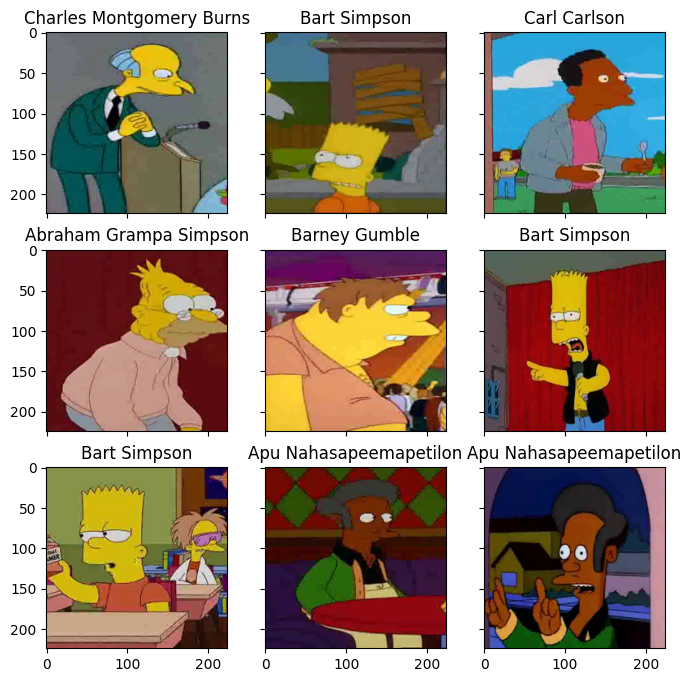

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Building a neural network


In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Let's complete the network with 2 fully connected layers

        self.fc1 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 4096),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

        self.out = nn.Linear(4096, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)

        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    if scheduler is not None:
      scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True) # amsgrad
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1) # adding scheduler
        criterion = nn.CrossEntropyLoss()
        # scheduler = torch.optim.lr_scheduler.CyclicLR(
        #    opt, base_lr=1e-4, max_lr=6e-4, cycle_momentum=False, mode="triangular2", step_size_up=2000
        # ) # плохо работает, к сожалению, решил попробовать после этой статьи (https://arxiv.org/pdf/1506.01186.pdf)

# Loss function.

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_f

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=15, batch_size=128)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 3.0191557403278697


epoch:   7%|▋         | 1/15 [02:30<35:03, 150.25s/it]


Epoch 001 train_loss: 3.0192     val_loss 2.5148 train_acc 0.1355 val_acc 0.2959
loss 1.9510518362191203


epoch:  13%|█▎        | 2/15 [05:01<32:39, 150.75s/it]


Epoch 002 train_loss: 1.9511     val_loss 1.6389 train_acc 0.4482 val_acc 0.5267
loss 1.2794415927691114


epoch:  20%|██        | 3/15 [07:33<30:15, 151.32s/it]


Epoch 003 train_loss: 1.2794     val_loss 1.0937 train_acc 0.6331 val_acc 0.6912
loss 0.8931897035889796


epoch:  27%|██▋       | 4/15 [10:05<27:46, 151.52s/it]


Epoch 004 train_loss: 0.8932     val_loss 0.9171 train_acc 0.7430 val_acc 0.7398
loss 0.6821270498760764


epoch:  33%|███▎      | 5/15 [12:38<25:20, 152.04s/it]


Epoch 005 train_loss: 0.6821     val_loss 0.7926 train_acc 0.8011 val_acc 0.7784
loss 0.4063385440305628


epoch:  40%|████      | 6/15 [15:12<22:55, 152.86s/it]


Epoch 006 train_loss: 0.4063     val_loss 0.6906 train_acc 0.8878 val_acc 0.8166
loss 0.331537679271551


epoch:  47%|████▋     | 7/15 [17:44<20:19, 152.39s/it]


Epoch 007 train_loss: 0.3315     val_loss 0.6856 train_acc 0.9061 val_acc 0.8194
loss 0.29307750733849863


epoch:  53%|█████▎    | 8/15 [20:14<17:42, 151.75s/it]


Epoch 008 train_loss: 0.2931     val_loss 0.6790 train_acc 0.9181 val_acc 0.8248
loss 0.25968802986885225


epoch:  60%|██████    | 9/15 [22:36<14:51, 148.64s/it]


Epoch 009 train_loss: 0.2597     val_loss 0.6833 train_acc 0.9294 val_acc 0.8261
loss 0.2238751196832412


epoch:  67%|██████▋   | 10/15 [24:58<12:14, 146.80s/it]


Epoch 010 train_loss: 0.2239     val_loss 0.6887 train_acc 0.9388 val_acc 0.8309
loss 0.19111884620506464


epoch:  73%|███████▎  | 11/15 [27:19<09:39, 144.86s/it]


Epoch 011 train_loss: 0.1911     val_loss 0.6864 train_acc 0.9491 val_acc 0.8323
loss 0.1795595301622129


epoch:  80%|████████  | 12/15 [29:42<07:13, 144.49s/it]


Epoch 012 train_loss: 0.1796     val_loss 0.6905 train_acc 0.9539 val_acc 0.8311
loss 0.18321355056539448


epoch:  87%|████████▋ | 13/15 [32:03<04:46, 143.36s/it]


Epoch 013 train_loss: 0.1832     val_loss 0.6935 train_acc 0.9514 val_acc 0.8315
loss 0.17771990898327658


epoch:  93%|█████████▎| 14/15 [34:27<02:23, 143.56s/it]


Epoch 014 train_loss: 0.1777     val_loss 0.6947 train_acc 0.9535 val_acc 0.8298
loss 0.17525575734512147


epoch: 100%|██████████| 15/15 [36:52<00:00, 147.49s/it]


Epoch 015 train_loss: 0.1753     val_loss 0.6963 train_acc 0.9532 val_acc 0.8307


In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9


In [ ]:
# Accuracy in kaggle

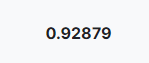

In [ ]:
# Let's test on resnet18 model with pre-trained data

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# num_features -- replacing last layer
num_features = 512
model.fc = nn.Linear(num_features, 42)

In [ ]:
n_classes = len(np.unique(train_val_labels))
resnet_model = model.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(resnet_model)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True) # amsgrad
        criterion = nn.CrossEntropyLoss()

# Loss function.

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
history = train(train_dataset, val_dataset, model=resnet_model, epochs=12, batch_size=128)

epoch:   0%|          | 0/12 [00:00<?, ?it/s]

loss 1.1250022913257107


epoch:   8%|▊         | 1/12 [03:13<35:32, 193.90s/it]


Epoch 001 train_loss: 1.1250     val_loss 0.4387 train_acc 0.7611 val_acc 0.9106
loss 0.2995050275403228


epoch:  17%|█▋        | 2/12 [06:23<31:52, 191.26s/it]


Epoch 002 train_loss: 0.2995     val_loss 0.2819 train_acc 0.9241 val_acc 0.9259
loss 0.14183199710926134


epoch:  25%|██▌       | 3/12 [09:29<28:22, 189.15s/it]


Epoch 003 train_loss: 0.1418     val_loss 0.1960 train_acc 0.9632 val_acc 0.9503
loss 0.09729665166563316


epoch:  33%|███▎      | 4/12 [13:13<27:01, 202.69s/it]


Epoch 004 train_loss: 0.0973     val_loss 0.2125 train_acc 0.9742 val_acc 0.9427
loss 0.05760477005289735


epoch:  42%|████▏     | 5/12 [16:36<23:38, 202.69s/it]


Epoch 005 train_loss: 0.0576     val_loss 0.1925 train_acc 0.9856 val_acc 0.9498
loss 0.041895105422582


epoch:  50%|█████     | 6/12 [19:56<20:11, 201.93s/it]


Epoch 006 train_loss: 0.0419     val_loss 0.1812 train_acc 0.9886 val_acc 0.9564
loss 0.026460661062773446


epoch:  58%|█████▊    | 7/12 [22:59<16:18, 195.71s/it]


Epoch 007 train_loss: 0.0265     val_loss 0.1746 train_acc 0.9927 val_acc 0.9589
loss 0.03034719427607


epoch:  67%|██████▋   | 8/12 [25:58<12:42, 190.52s/it]


Epoch 008 train_loss: 0.0303     val_loss 0.1919 train_acc 0.9922 val_acc 0.9585
loss 0.02014342793717618


epoch:  75%|███████▌  | 9/12 [28:57<09:20, 186.91s/it]


Epoch 009 train_loss: 0.0201     val_loss 0.1662 train_acc 0.9948 val_acc 0.9627
loss 0.021170650424044316


epoch:  83%|████████▎ | 10/12 [31:57<06:09, 184.77s/it]


Epoch 010 train_loss: 0.0212     val_loss 0.1941 train_acc 0.9934 val_acc 0.9561
loss 0.017390269255513565


epoch:  92%|█████████▏| 11/12 [34:56<03:02, 182.92s/it]


Epoch 011 train_loss: 0.0174     val_loss 0.1777 train_acc 0.9954 val_acc 0.9626
loss 0.00713948085947576


epoch: 100%|██████████| 12/12 [37:54<00:00, 189.53s/it]


Epoch 012 train_loss: 0.0071     val_loss 0.2128 train_acc 0.9981 val_acc 0.9532


In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet_model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet_model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9


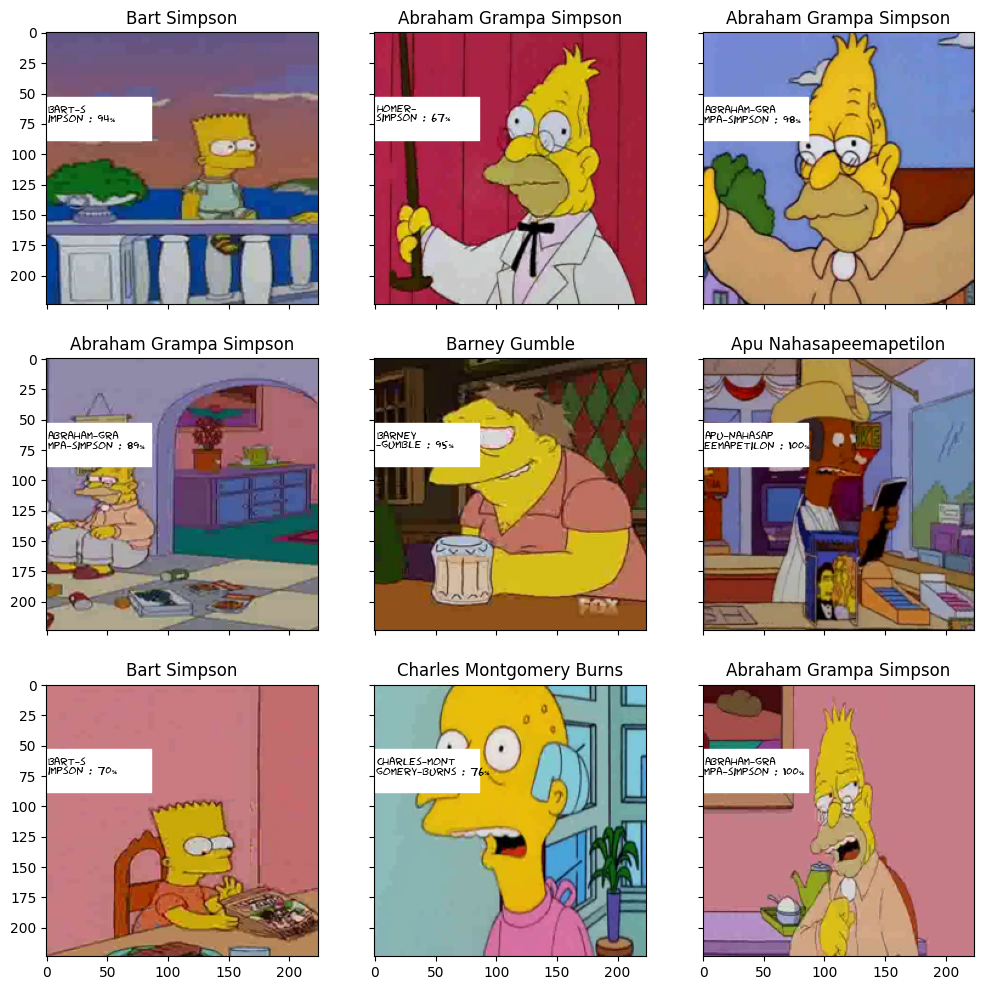

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit on Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv	 testset
gdrive			     sample_data	simple_cnn_baseline.csv  train


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
probs = predict(simple_cnn, test_loader)
preds = [label_encoder.classes_[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit= pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
})

my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)